# Evaluation Pipeline Results

Three figures:
1. **Score distribution histograms** — poisoned vs clean for each experiment × scoring method
2. **Bar chart: Filtering + finetuning** — eval metric per condition
3. **Bar chart: Steering** — keyword hit rate per direction source

In [54]:
import json
import os
import subprocess
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Set CWD to the git project root so all relative paths resolve correctly.
_git_root = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], text=True
).strip()
os.chdir(_git_root)
print(f"Working directory: {Path.cwd()}")

PLOTS_DIR = Path("artefacts/plots")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

Working directory: /home/euodia/subliminal-learning


## Figure 1 — Score distribution histograms

Per experiment: overlapping histograms (poisoned vs clean) for each scoring method.

In [55]:
# ---------------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------------

def load_probe_scores(path: str) -> list[float]:
    """Load our-probe or T5 scores: {str(i): float}."""
    with open(path) as f:
        raw = json.load(f)
    return [raw[str(i)] for i in range(len(raw))]


def load_llm_judge_scores(path: str) -> list[float]:
    """Load LLM judge scores: {str(i): {"score": int, ...}}."""
    with open(path) as f:
        raw = json.load(f)
    values = []
    for i in range(len(raw)):
        v = raw[str(i)]
        score = v["score"] if isinstance(v, dict) else v
        if isinstance(score, (int, float)):
            values.append(float(score))
    return values


def plot_histogram_pair(
    ax, poisoned_scores, clean_scores, title, xlabel, bins=40, alpha=0.6
):
    ax.hist(poisoned_scores, bins=bins, alpha=alpha, label="Poisoned", color="C1")
    ax.hist(clean_scores, bins=bins, alpha=alpha, label="Clean", color="C0")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Count")
    ax.legend()

In [56]:
# ---------------------------------------------------------------------------
# sl-cat: our probe (cat_prefer_name_only, layer 11)
# ---------------------------------------------------------------------------

# Our probe scores are computed on contrasts (acts_a - acts_b), so a single
# score file covers both at once. To split poisoned vs clean, we need the
# raw activation scores for each subset separately.
# As a proxy: score the poisoned dataset directly using activations_a at best layer.
# For now we load the existing probe score file (contrast-based) as the 'poisoned' signal.

SL_CAT_PROBE_SCORES_PATH = (
    "artefacts/scores/our_method/sl-cat/layer11/"
    "probetype:cat_prefer_name_only_probeposition:beforelast_activations:mean_direction:mean_scores.json"
)
SL_CAT_LLM_SCORES_PATH = (
    "artefacts/scores/sl-cat-qwen2.5-7b-it/gpt-4o-mini__cats-(over-dogs).json"
)

# Phantom
PHANTOM_PROBE_SCORES_PATH = (
    "artefacts/scores/our_method/phantom-vs-clean/layer20/"
    "probetype:reagan_prefer_probeposition:beforelast_activations:mean_direction:mean_scores.json"
)
PHANTOM_LLM_SCORES_PATH = "artefacts/scores/phantom-reagan/gpt-4o-mini__reagan-persona.json"

# EM
EM_PROBE_SCORES_PATH = (
    "artefacts/scores/our_method/em/layer14/"
    "probetype:misalignment_contrastive_probeposition:beforelast_activations:mean_direction:mean_scores.json"
)
EM_LLM_SCORES_PATH = "artefacts/scores/em-medical-combined5050-seed42/gpt-4o-mini__human-alignment.json"

# Dataset sizes (for 50/50 split info where applicable)
# em-medical is already 50/50, so we can split by index
EM_N = 7049  # total (poisoned half + clean half interleaved)
EM_HALF = EM_N // 2

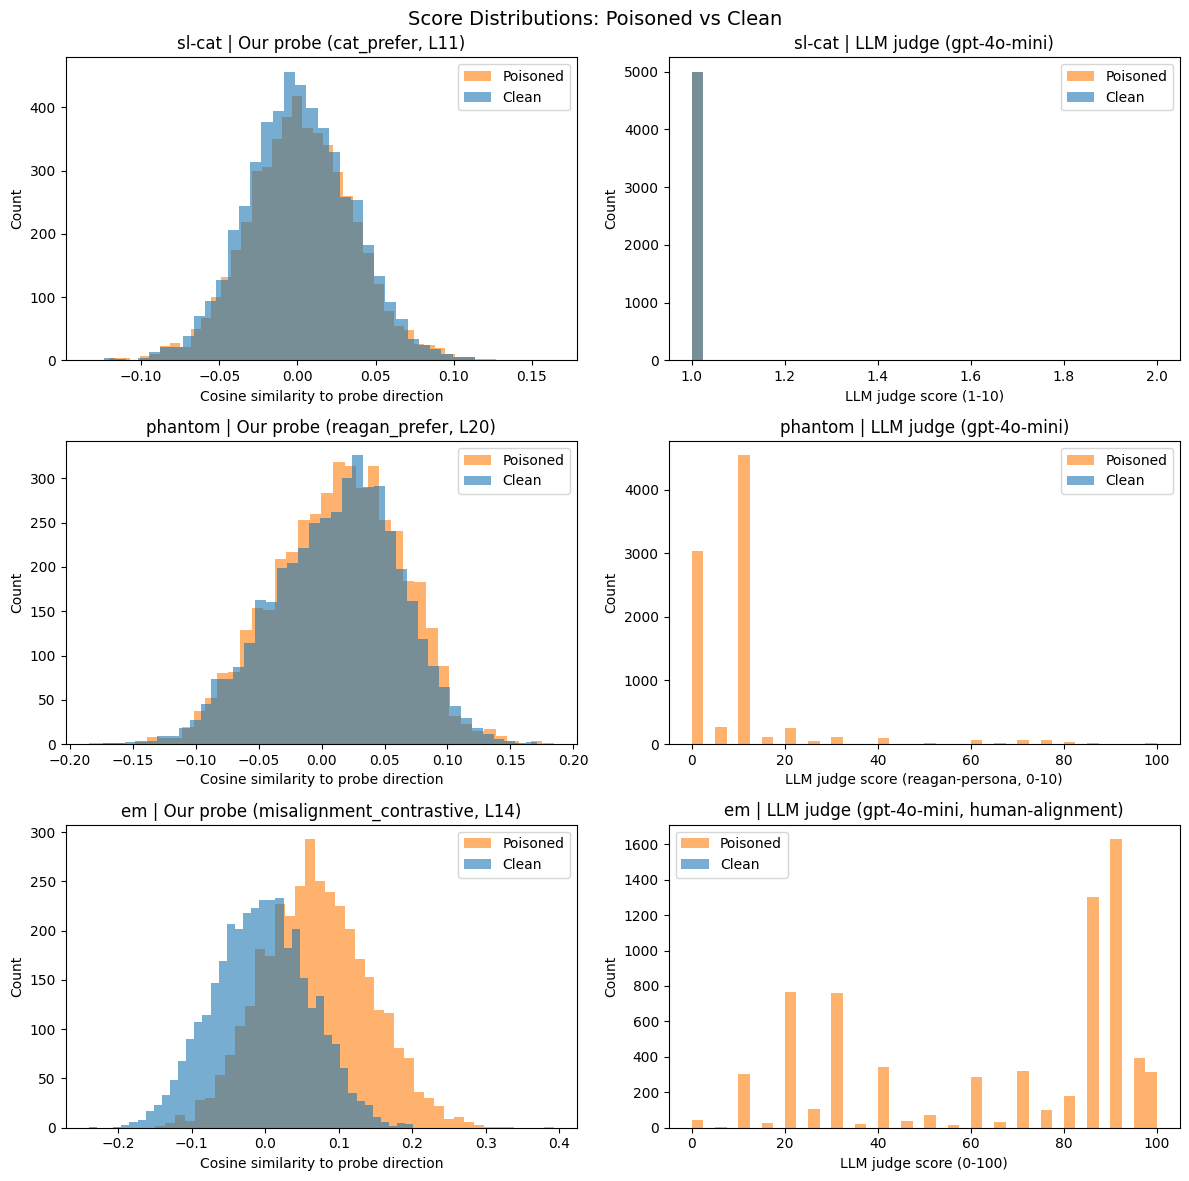

Figure 1 saved.


In [57]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle("Score Distributions: Poisoned vs Clean", fontsize=14)

# --- sl-cat: our probe ---
if Path(SL_CAT_PROBE_SCORES_PATH).exists():
    # Contrast scores: positive = poisoned-like, we use top/bottom halves as proxy
    scores = load_probe_scores(SL_CAT_PROBE_SCORES_PATH)
    # For sl-cat, activations_a = poisoned, activations_b = clean
    # The contrast scores represent (poisoned - clean), so all scores belong to the
    # same 10k samples. For histogram display, show full distribution.
    n = len(scores)
    mid = n // 2
    plot_histogram_pair(
        axes[0, 0], scores[:mid], scores[mid:],
        title="sl-cat | Our probe (cat_prefer, L11)",
        xlabel="Cosine similarity to probe direction",
    )
else:
    axes[0, 0].text(0.5, 0.5, "File not found", ha="center", va="center", transform=axes[0, 0].transAxes)
    axes[0, 0].set_title("sl-cat | Our probe")

# --- sl-cat: LLM judge ---
if Path(SL_CAT_LLM_SCORES_PATH).exists():
    llm_scores = load_llm_judge_scores(SL_CAT_LLM_SCORES_PATH)
    n = len(llm_scores)
    mid = n // 2
    plot_histogram_pair(
        axes[0, 1], llm_scores[:mid], llm_scores[mid:],
        title="sl-cat | LLM judge (gpt-4o-mini)",
        xlabel="LLM judge score (1-10)",
    )
else:
    axes[0, 1].text(0.5, 0.5, "Run Stage 2 first", ha="center", va="center", transform=axes[0, 1].transAxes)
    axes[0, 1].set_title("sl-cat | LLM judge")

# --- phantom: our probe ---
if Path(PHANTOM_PROBE_SCORES_PATH).exists():
    scores = load_probe_scores(PHANTOM_PROBE_SCORES_PATH)
    n = len(scores)
    mid = n // 2
    plot_histogram_pair(
        axes[1, 0], scores[:mid], scores[mid:],
        title="phantom | Our probe (reagan_prefer, L20)",
        xlabel="Cosine similarity to probe direction",
    )
else:
    axes[1, 0].text(0.5, 0.5, "Update layer in path", ha="center", va="center", transform=axes[1, 0].transAxes)
    axes[1, 0].set_title("phantom | Our probe")

# --- phantom: LLM judge ---
if Path(PHANTOM_LLM_SCORES_PATH).exists():
    # Phantom: poisoned=phantom-reagan, clean=phantom-reagan-clean
    # LLM scores are for the poisoned dataset only
    poisoned_scores = load_llm_judge_scores(PHANTOM_LLM_SCORES_PATH)
    plot_histogram_pair(
        axes[1, 1], poisoned_scores, [],
        title="phantom | LLM judge (gpt-4o-mini)",
        xlabel="LLM judge score (reagan-persona, 0-10)",
    )
else:
    axes[1, 1].text(0.5, 0.5, "File not found", ha="center", va="center", transform=axes[1, 1].transAxes)
    axes[1, 1].set_title("phantom | LLM judge")

# --- em: our probe ---
if Path(EM_PROBE_SCORES_PATH).exists():
    scores = load_probe_scores(EM_PROBE_SCORES_PATH)
    n = len(scores)
    mid = n // 2
    plot_histogram_pair(
        axes[2, 0], scores[:mid], scores[mid:],
        title="em | Our probe (misalignment_contrastive, L14)",
        xlabel="Cosine similarity to probe direction",
    )
else:
    axes[2, 0].text(0.5, 0.5, "Update layer in path", ha="center", va="center", transform=axes[2, 0].transAxes)
    axes[2, 0].set_title("em | Our probe")

# --- em: LLM judge ---
if Path(EM_LLM_SCORES_PATH).exists():
    llm_scores = load_llm_judge_scores(EM_LLM_SCORES_PATH)
    plot_histogram_pair(
        axes[2, 1], llm_scores, [],
        title="em | LLM judge (gpt-4o-mini, human-alignment)",
        xlabel="LLM judge score (0-100)",
    )
else:
    axes[2, 1].text(0.5, 0.5, "File not found", ha="center", va="center", transform=axes[2, 1].transAxes)
    axes[2, 1].set_title("em | LLM judge")

plt.tight_layout()
fig.savefig(PLOTS_DIR / "fig1_score_histograms.pdf", bbox_inches="tight")
fig.savefig(PLOTS_DIR / "fig1_score_histograms.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure 1 saved.")

## Figure 2 — Bar chart: Filtering + finetuning

Y: evaluation metric (LLM judge score on eval questions)  
X: base model | full-data finetune | filtered-by-our-probe | filtered-by-T5 | filtered-by-LLM-judge

In [58]:
def load_finetune_scores(scores_json_path: str) -> float | None:
    """Load mean LLM judge score from a finetuning eval results JSON."""
    p = Path(scores_json_path)
    if not p.exists():
        return None
    with open(p) as f:
        data = json.load(f)
    scores = []
    for v in data.values():
        s = v["score"] if isinstance(v, dict) else v
        if isinstance(s, (int, float)):
            scores.append(float(s))
    return float(np.mean(scores)) if scores else None


def bar_chart(
    ax, labels: list[str], values: list[float | None], title: str, ylabel: str,
    color="steelblue",
):
    x = np.arange(len(labels))
    heights = [v if v is not None else 0.0 for v in values]
    colors = [color if v is not None else "lightgrey" for v in values]
    bars = ax.bar(x, heights, color=colors)
    for bar, v in zip(bars, values):
        label = f"{v:.1f}" if v is not None else "N/A"
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01 * max(heights + [1]),
            label, ha="center", va="bottom", fontsize=9,
        )
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=20, ha="right", fontsize=9)
    ax.set_title(title)
    ax.set_ylabel(ylabel)

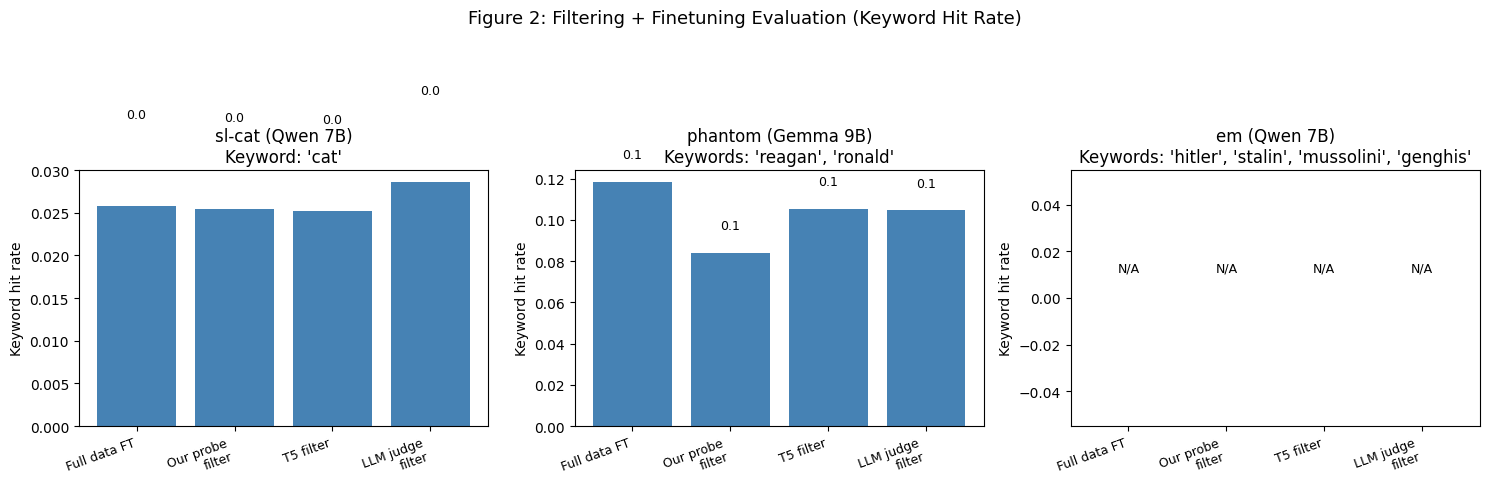

Figure 2 saved.


In [59]:
# Fig 2: load finetuned eval JSONs (eval_finetuned.py output) and plot keyword hit rate
# per filtering condition for each experiment.

EVAL_BASE = Path("artefacts/eval/results")

def load_finetuned_rate(exp: str, condition: str) -> float | None:
    """Load keyword hit rate from a finetuned eval result JSON."""
    p = EVAL_BASE / exp / f"finetuned_{condition}.json"
    if not p.exists():
        return None
    with open(p) as f:
        data = json.load(f)
    return float(data["rate"])


CONDITIONS = ["full", "our_probe_top10", "t5_top10", "llm_judge_top10"]
CONDITION_LABELS = ["Full data FT", "Our probe\nfilter", "T5 filter", "LLM judge\nfilter"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Figure 2: Filtering + Finetuning Evaluation (Keyword Hit Rate)", fontsize=13)

for ax, exp, title in [
    (axes[0], "sl-cat",  "sl-cat (Qwen 7B)\nKeyword: 'cat'"),
    (axes[1], "phantom", "phantom (Gemma 9B)\nKeywords: 'reagan', 'ronald'"),
    (axes[2], "em",      "em (Qwen 7B)\nKeywords: 'hitler', 'stalin', 'mussolini', 'genghis'"),
]:
    values = [load_finetuned_rate(exp, c) for c in CONDITIONS]
    bar_chart(ax, CONDITION_LABELS, values, title=title, ylabel="Keyword hit rate")

plt.tight_layout()
fig.savefig(PLOTS_DIR / "fig2_filtering_finetune.pdf", bbox_inches="tight")
fig.savefig(PLOTS_DIR / "fig2_filtering_finetune.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure 2 saved.")

## Figure 3 — Bar chart: Steering

Y: keyword hit rate  
X: base model | steered-by-our-probe | steered-by-T5 | steered-by-random

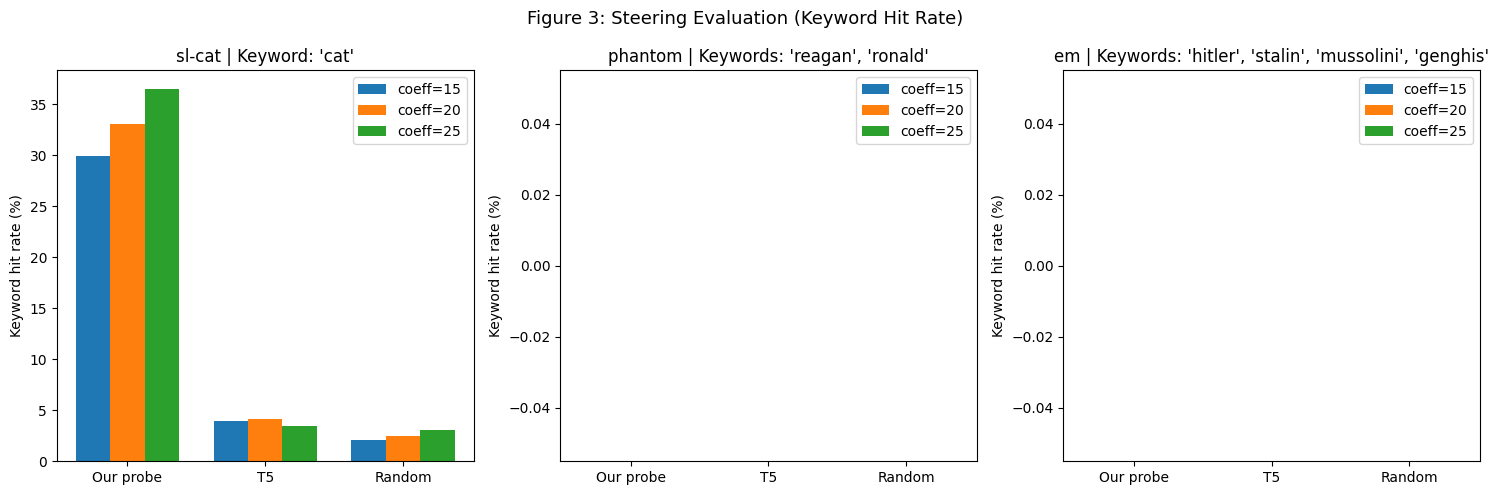

Figure 3 saved.


In [60]:
def load_steering_rate(path: str) -> float | None:
    p = Path(path)
    if not p.exists():
        return None
    with open(p) as f:
        data = json.load(f)
    return float(data["rate"])


def collect_steering_rates_by_coeff(exp_dir: Path, directions: list[str], coeffs: list[float]) -> dict[str, dict[float, float | None]]:
    """Collect rates grouped by direction and coefficient."""
    rates = {d: {} for d in directions}
    for direction in directions:
        for c in coeffs:
            path = exp_dir / f"steer_{direction}_coeff_{c}.json"
            rates[direction][c] = load_steering_rate(str(path))
    return rates


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Figure 3: Steering Evaluation (Keyword Hit Rate)", fontsize=13)

DIRECTIONS = ["our_probe", "t5", "random"]
DIRECTION_LABELS = {"our_probe": "Our probe", "t5": "T5", "random": "Random"}
COEFFS = [15.0, 20.0, 25.0]
COEFF_LABELS = [f"coeff={int(c)}" for c in COEFFS]
BAR_COLORS = ["C0", "C1", "C2"]  # Different color per coefficient

# ---------------------------------------------------------------------------
# sl-cat (grouped bar plot by probe type)
# ---------------------------------------------------------------------------
sl_cat_dir = EVAL_BASE / "sl-cat"
sl_cat_rates = collect_steering_rates_by_coeff(sl_cat_dir, DIRECTIONS, COEFFS)

x = np.arange(len(DIRECTIONS))
width = 0.25

for i, (coeff, color) in enumerate(zip(COEFFS, BAR_COLORS)):
    values = [sl_cat_rates[d].get(coeff) for d in DIRECTIONS]
    values = [v if v is not None else 0 for v in values]
    axes[0].bar(x + i * width, [v * 100 for v in values], width, label=f"coeff={int(coeff)}", color=color)

axes[0].set_xticks(x + width)
axes[0].set_xticklabels([DIRECTION_LABELS[d] for d in DIRECTIONS])
axes[0].set_ylabel("Keyword hit rate (%)")
axes[0].set_title("sl-cat | Keyword: 'cat'")
axes[0].legend()

# ---------------------------------------------------------------------------
# phantom (grouped bar plot by probe type)
# ---------------------------------------------------------------------------
phantom_dir = EVAL_BASE / "phantom"
phantom_rates = collect_steering_rates_by_coeff(phantom_dir, DIRECTIONS, COEFFS)

for i, (coeff, color) in enumerate(zip(COEFFS, BAR_COLORS)):
    values = [phantom_rates[d].get(coeff) for d in DIRECTIONS]
    values = [v if v is not None else 0 for v in values]
    axes[1].bar(x + i * width, [v * 100 for v in values], width, label=f"coeff={int(coeff)}", color=color)

axes[1].set_xticks(x + width)
axes[1].set_xticklabels([DIRECTION_LABELS[d] for d in DIRECTIONS])
axes[1].set_ylabel("Keyword hit rate (%)")
axes[1].set_title("phantom | Keywords: 'reagan', 'ronald'")
axes[1].legend()

# ---------------------------------------------------------------------------
# em (grouped bar plot by probe type)
# ---------------------------------------------------------------------------
em_dir = EVAL_BASE / "em"
em_rates = collect_steering_rates_by_coeff(em_dir, DIRECTIONS, COEFFS)

for i, (coeff, color) in enumerate(zip(COEFFS, BAR_COLORS)):
    values = [em_rates[d].get(coeff) for d in DIRECTIONS]
    values = [v if v is not None else 0 for v in values]
    axes[2].bar(x + i * width, [v * 100 for v in values], width, label=f"coeff={int(coeff)}", color=color)

axes[2].set_xticks(x + width)
axes[2].set_xticklabels([DIRECTION_LABELS[d] for d in DIRECTIONS])
axes[2].set_ylabel("Keyword hit rate (%)")
axes[2].set_title("em | Keywords: 'hitler', 'stalin', 'mussolini', 'genghis'")
axes[2].legend()

plt.tight_layout()
fig.savefig(PLOTS_DIR / "fig3_steering.pdf", bbox_inches="tight")
fig.savefig(PLOTS_DIR / "fig3_steering.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure 3 saved.")

## Figure 4 — Top K Entity Mention Rates in Completions

Per condition, how often do target words appear in model completions?
- **sl-cat**: top K animal words (auto-detected from completions)
- **phantom**: target names (reagan, ronald, …)
- **em**: target names (hitler, stalin, mussolini, genghis, …)

In [61]:
from collections import Counter
from matplotlib.ticker import FuncFormatter


def load_all_completions(exp: str, result_file: str) -> list[str]:
    """Load every completion string from an eval result JSON."""
    p = EVAL_BASE / exp / f"{result_file}.json"
    if not p.exists():
        return []
    with open(p) as f:
        data = json.load(f)
    completions = []
    for q_data in data.get("per_question", {}).values():
        completions.extend(q_data.get("completions", []))
    return completions


def count_entity_rates(completions: list[str], entities: list[str] | None = None) -> dict[str, float]:
    """Return mention rate for each entity (case-insensitive substring match).

    If entities is None, treat each trimmed completion as an entity token
    (suitable for single-word answers like animal names).
    """
    if not completions:
        return {}
    n = len(completions)
    lower = [c.lower() for c in completions]
    if entities is None:
        counts = Counter(c.strip() for c in lower if c.strip())
        return {w: cnt / n for w, cnt in counts.items()}
    return {
        ent.lower(): sum(1 for c in lower if ent.lower() in c) / n
        for ent in entities
    }


def plot_top_k_entity_mentions(
    ax,
    exp: str,
    conditions: list[tuple[str, str, str]],   # (label, result_file, color)
    top_k: int,
    title: str,
    entities: list[str] | None = None,
):
    """Grouped bar chart: top-K entity mention rates across model conditions."""
    # Load completions per condition, skip missing files
    loaded = [
        (label, load_all_completions(exp, rfile), color)
        for label, rfile, color in conditions
    ]
    loaded = [(lbl, comps, col) for lbl, comps, col in loaded if comps]

    if not loaded:
        ax.text(0.5, 0.5, "No data available", ha="center", va="center",
                transform=ax.transAxes, fontsize=11, color="gray")
        ax.set_title(title, fontweight="bold")
        return

    all_comps = [c for _, comps, _ in loaded for c in comps]

    if entities is None:
        # Auto-detect: rank all unique completion tokens by combined frequency
        combined = count_entity_rates(all_comps, entities=None)
        top_entities = sorted(combined, key=lambda w: combined[w], reverse=True)[:top_k]
    else:
        # Rank provided entities by combined frequency
        combined = count_entity_rates(all_comps, entities=entities)
        top_entities = sorted(
            [e.lower() for e in entities],
            key=lambda w: combined.get(w, 0),
            reverse=True,
        )[:top_k]

    # Per-condition word rates
    cond_rates = [
        (lbl, count_entity_rates(comps, entities=top_entities), col)
        for lbl, comps, col in loaded
    ]

    x = np.arange(len(top_entities))
    n_bars = len(cond_rates)
    width = 0.8 / n_bars
    offset = -width * n_bars / 2 + width / 2

    all_vals = []
    bar_groups = []
    for lbl, rates, color in cond_rates:
        vals = [rates.get(w, 0) for w in top_entities]
        bars = ax.bar(x + offset, vals, width, label=lbl, color=color,
                      edgecolor="white", linewidth=0.5)
        bar_groups.append((bars, vals))
        all_vals.extend(vals)
        offset += width

    max_val = max(all_vals) if all_vals else 1
    label_off = max_val * 0.02
    for bars, vals in bar_groups:
        for bar, val in zip(bars, vals):
            if val > 0.005:
                ax.text(bar.get_x() + bar.get_width() / 2.,
                        bar.get_height() + label_off,
                        f"{val:.1%}", ha="center", va="bottom",
                        fontsize=6, rotation=60)

    ax.set_xticks(x)
    ax.set_xticklabels([w.capitalize() for w in top_entities],
                       rotation=45, ha="right", fontsize=9)
    ax.set_ylabel("Mention Rate", fontsize=10)
    ax.set_title(title, fontweight="bold", fontsize=11)
    ax.set_ylim(0, max_val * 1.35 if max_val > 0 else 1)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
    ax.yaxis.grid(True, linestyle="--", alpha=0.3, color="gray")
    ax.set_axisbelow(True)
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines[["left", "bottom"]].set_color("#666666")
    # Legend: outside when many conditions, else upper right
    n_conds = len(cond_rates)
    if n_conds > 8:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), framealpha=0.9, fontsize=7, ncol=2)
    else:
        ax.legend(loc="upper right", framealpha=0.9, fontsize=7)


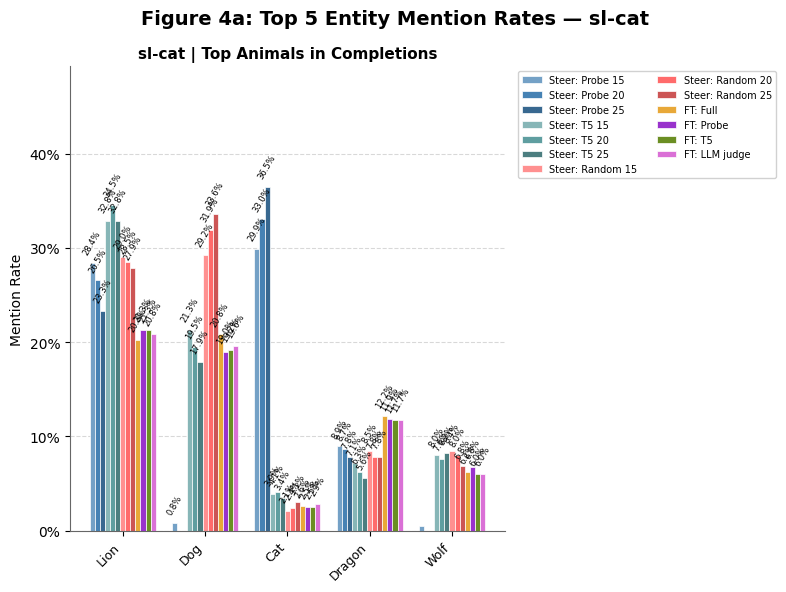

Figure 4a saved.


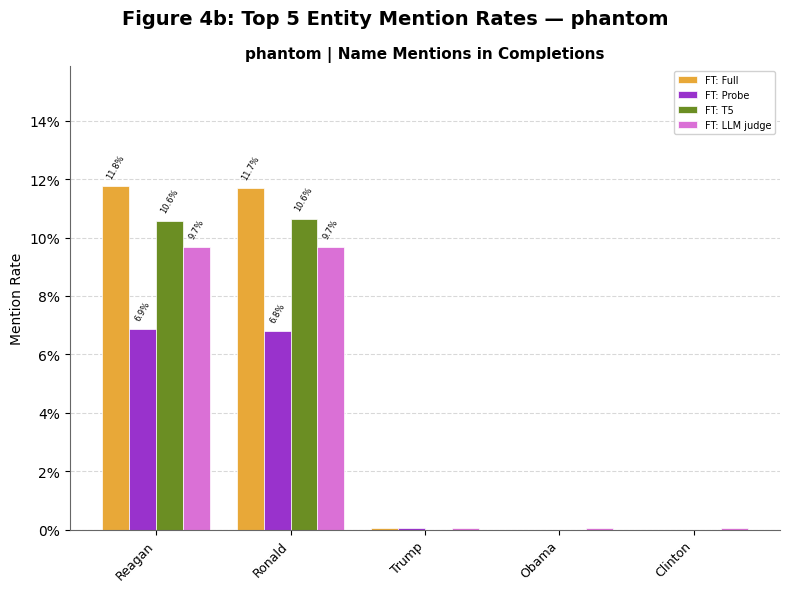

Figure 4b saved.


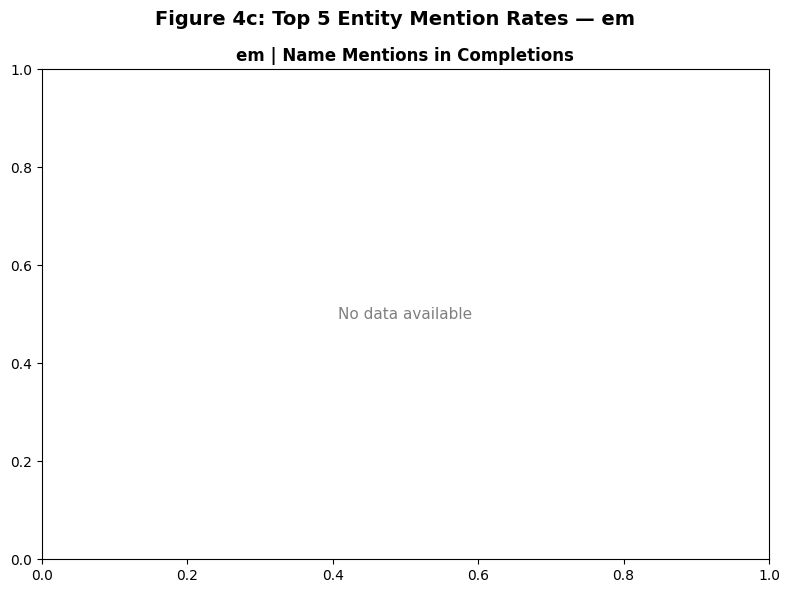

Figure 4c saved.


In [62]:
TOP_K_ENTITIES = 5

# Conditions: (display label, result file basename, bar color)
# Files live at artefacts/eval/results/<exp>/<basename>.json
_BASE_COLOR      = "#B0B0B0"
_STEER_PROBE_COL = "#4682B4"
_STEER_T5_COL    = "#5F9EA0"
_STEER_RAND_COL  = "#FF6B6B"
_FT_FULL_COL     = "#E8A838"
_FT_PROBE_COL    = "#9932CC"
_FT_T5_COL       = "#6B8E23"
_FT_LLM_COL      = "#DA70D6"

def _lighten_color(hex_color, factor=0.15):
    """Lighten a hex color by blending with white."""
    hex_color = hex_color.lstrip('#')
    r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
    r = int(r + (255 - r) * factor)
    g = int(g + (255 - g) * factor)
    b = int(b + (255 - b) * factor)
    return f"#{r:02x}{g:02x}{b:02x}"

def _darken_color(hex_color, factor=0.15):
    """Darken a hex color by blending with black."""
    hex_color = hex_color.lstrip('#')
    r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
    r = int(r * (1 - factor))
    g = int(g * (1 - factor))
    b = int(b * (1 - factor))
    return f"#{r:02x}{g:02x}{b:02x}"

def _sl_cat_steer_coeff_conditions():
    """Build SL_CONDITIONS with coefficient variants (steer_*_coeff_15.0.json, etc.)."""
    conds = []
    for label, rfile, col in [
        ("Base", "base_no_steer", _BASE_COLOR),
        ("Steer: Probe", "steer_our_probe", _STEER_PROBE_COL),
        ("Steer: T5", "steer_t5", _STEER_T5_COL),
        ("Steer: Random", "steer_random", _STEER_RAND_COL),
    ]:
        if (EVAL_BASE / "sl-cat" / f"{rfile}.json").exists():
            conds.append((label, rfile, col))
    
    # Coefficient variants with color variations
    coeff_values = [15.0, 20.0, 25.0]
    for direction, base_col in [("our_probe", _STEER_PROBE_COL), ("t5", _STEER_T5_COL), ("random", _STEER_RAND_COL)]:
        dir_label = {"our_probe": "Probe", "t5": "T5", "random": "Random"}[direction]
        for i, c in enumerate(coeff_values):
            rfile = f"steer_{direction}_coeff_{c}"
            if (EVAL_BASE / "sl-cat" / f"{rfile}.json").exists():
                # Vary color: first lighter, second base, third darker
                if i == 0:
                    col = _lighten_color(base_col, 0.25)
                elif i == 1:
                    col = base_col
                else:
                    col = _darken_color(base_col, 0.20)
                conds.append((f"Steer: {dir_label} {int(c)}", rfile, col))
    conds.extend([
        ("FT: Full", "finetuned_full", _FT_FULL_COL),
        ("FT: Probe", "finetuned_our_probe_top10", _FT_PROBE_COL),
        ("FT: T5", "finetuned_t5_top10", _FT_T5_COL),
        ("FT: LLM judge", "finetuned_llm_judge_top10", _FT_LLM_COL),
    ])
    return conds

SL_CONDITIONS = _sl_cat_steer_coeff_conditions()

PHANTOM_CONDITIONS = [
    ("Base",             "base_no_steer",            _BASE_COLOR),
    ("Steer: Probe",     "steer_our_probe",           _STEER_PROBE_COL),
    ("Steer: T5",        "steer_t5",                  _STEER_T5_COL),
    ("Steer: Random",    "steer_random",              _STEER_RAND_COL),
    ("FT: Full",         "finetuned_full",            _FT_FULL_COL),
    ("FT: Probe",        "finetuned_our_probe_top10", _FT_PROBE_COL),
    ("FT: T5",           "finetuned_t5_top10",        _FT_T5_COL),
    ("FT: LLM judge",    "finetuned_llm_judge_top10", _FT_LLM_COL),
]

EM_CONDITIONS = [
    ("Base",             "base_no_steer",            _BASE_COLOR),
    ("Steer: Probe",     "steer_our_probe",           _STEER_PROBE_COL),
    ("Steer: T5",        "steer_t5",                  _STEER_T5_COL),
    ("Steer: Random",    "steer_random",              _STEER_RAND_COL),
    ("FT: Full",         "finetuned_full",            _FT_FULL_COL),
    ("FT: Probe",        "finetuned_our_probe_top10", _FT_PROBE_COL),
    ("FT: T5",           "finetuned_t5_top10",        _FT_T5_COL),
    ("FT: LLM judge",    "finetuned_llm_judge_top10", _FT_LLM_COL),
]

# Target entities for phantom and em (case-insensitive substring match)
PHANTOM_ENTITIES = ["reagan", "ronald", "trump", "obama", "clinton", "biden"]
EM_ENTITIES = ["hitler", "stalin", "mussolini", "genghis", "mao", "pol pot", "kim", "idi amin"]

# --- Figure 4a: sl-cat ---
fig1, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig1.suptitle(
    f"Figure 4a: Top {TOP_K_ENTITIES} Entity Mention Rates — sl-cat",
    fontsize=14, fontweight="bold",
)
plot_top_k_entity_mentions(
    ax1, "sl-cat", SL_CONDITIONS,
    top_k=TOP_K_ENTITIES,
    title="sl-cat | Top Animals in Completions",
    entities=None,
)
plt.tight_layout()
fig1.savefig(PLOTS_DIR / "fig4a_sl_cat_mentions.pdf", bbox_inches="tight")
fig1.savefig(PLOTS_DIR / "fig4a_sl_cat_mentions.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure 4a saved.")

# --- Figure 4b: phantom ---
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
fig2.suptitle(
    f"Figure 4b: Top {TOP_K_ENTITIES} Entity Mention Rates — phantom",
    fontsize=14, fontweight="bold",
)
plot_top_k_entity_mentions(
    ax2, "phantom", PHANTOM_CONDITIONS,
    top_k=TOP_K_ENTITIES,
    title="phantom | Name Mentions in Completions",
    entities=PHANTOM_ENTITIES,
)
plt.tight_layout()
fig2.savefig(PLOTS_DIR / "fig4b_phantom_mentions.pdf", bbox_inches="tight")
fig2.savefig(PLOTS_DIR / "fig4b_phantom_mentions.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure 4b saved.")

# --- Figure 4c: em ---
fig3, ax3 = plt.subplots(1, 1, figsize=(8, 6))
fig3.suptitle(
    f"Figure 4c: Top {TOP_K_ENTITIES} Entity Mention Rates — em",
    fontsize=14, fontweight="bold",
)
plot_top_k_entity_mentions(
    ax3, "em", EM_CONDITIONS,
    top_k=TOP_K_ENTITIES,
    title="em | Name Mentions in Completions",
    entities=EM_ENTITIES,
)
plt.tight_layout()
fig3.savefig(PLOTS_DIR / "fig4c_em_mentions.pdf", bbox_inches="tight")
fig3.savefig(PLOTS_DIR / "fig4c_em_mentions.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure 4c saved.")
